In [ ]:
import sys
#kaggle_env = False

#if not kaggle_env:
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#if not kaggle_env:
if 'google.colab' in sys.modules:
  #!pip install kaggle --upgrade
  !pip install --upgrade --force-reinstall --no-deps kaggle

  import os
  import json
  f = open("/content/drive/MyDrive/colab_notebooks/kaggle/kaggle.json", "r")
  json_data = json.load(f)
  os.environ["KAGGLE_USERNAME"] = json_data["username"]
  os.environ["KAGGLE_KEY"] = json_data["key"]

Requirement already up-to-date: kaggle in /usr/local/lib/python3.7/dist-packages (1.5.12)


In [ ]:
#if not kaggle_env:
if 'google.colab' in sys.modules:
  # Change current directory
  %cd /content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative

/content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative


In [ ]:
#if 'google.colab' in sys.modules:
  # Download Kaggle datasets related to this notebook
  ##!kaggle datasets list -s shahules/ner-coleridge-initiative
  #!mkdir input/ner-coleridge-initiative
  #!kaggle datasets download shahules/ner-coleridge-initiative -p input/ner-coleridge-initiative
  #!unzip input/ner-coleridge-initiative/ner-coleridge-initiative.zip -d input/ner-coleridge-initiative
  #!rm input/ner-coleridge-initiative/ner-coleridge-initiative.zip

In [ ]:
#if not kaggle_env:
if 'google.colab' in sys.modules:
  %cd notebooks

/content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/notebooks


In [ ]:
##!pip install NERDA
#!git clone https://github.com/riow1983/NERDA.git
#%cd NERDA
#!pip install -e .
#%cd ../
#!pwd

In [ ]:
# import multiprocessing
# from multiprocessing import Process
# from tqdm import tqdm

In [ ]:
# length = 1000
# def calc_sum(i, j):
#   return i + j

In [ ]:
# with multiprocessing.Pool() as pool:
#     process = [pool.apply_async(calc_sum, (i, j)) for j in range(length) for i in tqdm(range(length))]
#     sum_list = [f.get() for f in process]

In [ ]:
# len(sum_list)

In [ ]:
# import numpy as np
# np.array(sum_list).reshape(1000, 1000)

In [40]:
import yaml
from pprint import pprint
with open('../config/config.yml') as file:
    CFG = yaml.load(file)
pprint(CFG)

{'cv': True,
 'debug': False,
 'epochs': 5,
 'gettext': False,
 'learning_rate': 2e-05,
 'max_len': 512,
 'tags_vals': 'o o-dataset pad',
 'test_batch_size': 48,
 'text_len': 30000,
 'train': True,
 'train_batch_size': 32,
 'use_pos': False,
 'valid_batch_size': 16}


In [41]:
TRAIN = CFG["train"]
MAX_LEN = CFG["max_len"]
TAGS_VALS = CFG["tags_vals"]
#GETTEXT = CFG["gettext"]
USE_POS = CFG["use_pos"]
#CV = CFG["cv"]
DEBUG = CFG["debug"]
TEXT_LEN = CFG["text_len"]

!python ../src/bridge.py {TRAIN} {MAX_LEN} {USE_POS} {DEBUG} {TEXT_LEN} {TAGS_VALS}
# Appending...:  75% 377/500 [00:23<00:15,  8.07it/s]

Usage example:

!python bridge.py {train} {max_len} {gettext} {use_pos} {cv} {debug} {text_len} {tags_vals}

Args:
['True', '512', 'False', 'False', 'True', 'False', '30000', 'o', 'o-dataset', 'pad']
train: Bool: True
max_len: Int: 512
tags_vals: List[str]: ['o', 'o-dataset', 'pad']
gettext: Bool: False
use_pos: Bool: False
cv: Bool: True
debug: Bool: False
text_len: Int: 30000
Reading train data...
tcmalloc: large alloc 1073741824 bytes == 0x5588bbbb0000 @  0x7f20b7bb42a4 0x7f208ea179f5 0x7f208ea18d42 0x7f208ea1a45e 0x7f208e9ec068 0x7f208e9eb510 0x7f208e9e6f4e 0x7f208e9cbfe4 0x5588702e9cc0 0x5588703dafed 0x55887035d988 0x5588703587ad 0x5588702eb3ea 0x55887035960e 0x5588703584ae 0x5588702eb3ea 0x55887035960e 0x5588702eb30a 0x5588703593b5 0x5588703584ae 0x5588702eb3ea 0x55887035d7f0 0x5588703587ad 0x5588702eb3ea 0x55887035a32a 0x5588703584ae 0x5588703581b3 0x558870422182 0x5588704224fd 0x5588704223a6 0x5588703f9723
tcmalloc: large alloc 2147483648 bytes == 0x5588fbbb0000 @  0x7f20b7bb42

In [ ]:
import pandas as pd

In [ ]:
tmp = pd.read_csv("../input/kagglenb006-get-text/df_train.csv")
tmp

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,", stress satisfactory outcomes for all youth,..."
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Federal Reserve Bank of Richmond S1. Accountin...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This article investigates an important factor ...
...,...,...,...,...,...,...
19656,b3498176-8832-4033-aea6-b5ea85ea04c4,RSNA International Trends: A Global Perspectiv...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID Open Radiology Database,rsna international covid open radiology database,Our lives have been fundamentally altered this...
19657,f77eb51f-c3ac-420b-9586-cb187849c321,MCCS: a novel recognition pattern-based method...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,"The outbreak of the coronavirus disease 2019 ,..."
19658,ab59bcdd-7b7c-4107-93f5-0ccaf749236c,Quantitative Structure–Activity Relationship M...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,The ongoing COVID-19 pandemic has challenged t...
19659,fd23e7e0-a5d2-4f98-992d-9209c85153bb,A ligand-based computational drug repurposing ...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,deployment of approximative mathematical model...


In [ ]:
tmp["length"] = tmp["text"].apply(lambda x: len(x.split(" ")))

In [ ]:
tmp[tmp["length"] <= 30_000].shape[0]

19128

In [ ]:
tmp[tmp["length"] > 30_000].shape[0]

533

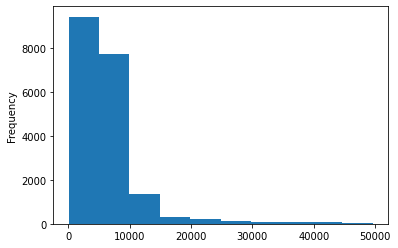

In [ ]:
tmp[tmp["length"] <= 50_000]["length"].plot.hist();

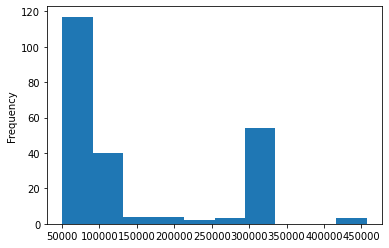

In [ ]:
tmp[(tmp["length"] > 50_000)&(tmp["length"] <= 600_000)]["length"].plot.hist();

In [42]:
tmp = pd.read_pickle("./dataset.pkl")
tmp

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text,word,pos,sentence,sentence#,tag,fold
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...,"[This, study, used, data, from, the, National,...",None,sentence0,"[sentence#0, sentence#0, sentence#0, sentence#...","[o, o, o, o, o, o, o-dataset, o-dataset, o-dat...",1
1,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,stress satisfactory outcomes for all youth inc...,"[stress, satisfactory, outcomes, for, all, you...",None,sentence2,"[sentence#0, sentence#0, sentence#0, sentence#...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",1
2,81b5f874-9b42-4d4f-8c50-b4bab24f8aed,The Gender Gap Reloaded: Are School Characteri...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study examines the wage gender gap of you...,"[This, study, examines, the, wage, gender, gap...",None,sentence5,"[sentence#0, sentence#0, sentence#0, sentence#...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",1
3,a3c998b6-ea9d-4542-9267-68f718247ff5,Who Values Access to College,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,dents thus may determine prior to enrolling th...,"[dents, thus, may, determine, prior, to, enrol...",None,sentence19,"[sentence#0, sentence#0, sentence#0, sentence#...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",1
4,0ebdaf88-543a-4d88-9185-a24f8dc1e4cf,Grade Inflation,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Although much speculation has been devoted to ...,"[Although, much, speculation, has, been, devot...",None,sentence21,"[sentence#0, sentence#0, sentence#0, sentence#...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
19656,01f926c6-a3a6-48c6-b463-1a5fbd0b57ef,Explainable Deep Learning for Pulmonary Diseas...,COVID-19 Image Data Collection,COVID-19 Image Data Collection,covid 19 image data collection,Coronaviruses represent an extended family of ...,"[Coronaviruses, represent, an, extended, famil...",None,sentence19644,"[sentence#0, sentence#0, sentence#0, sentence#...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",5
19657,bc3e118c-a17f-47d0-8171-9ca21d5754d1,A Multi-Stage Attentive Transfer Learning Fram...,COVID-19 Image Data Collection,COVID-19 Image Data Collection,covid 19 image data collection,T HE COVID 19 pandemic has spread rapidly and ...,"[T, HE, COVID, 19, pandemic, has, spread, rapi...",None,sentence19649,"[sentence#0, sentence#0, sentence#0, sentence#...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",5
19658,922a5f2c-2d1c-46a7-a07a-acaf2222c0c6,3D U-Net for segmentation of COVID-19 associat...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID-19 Open Radiology Dat...,rsna international covid 19 open radiology dat...,The Coronavirus Disease 2019 COVID 19 is an in...,"[The, Coronavirus, Disease, 2019, COVID, 19, i...",None,sentence19653,"[sentence#0, sentence#0, sentence#0, sentence#...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",5
19659,f77eb51f-c3ac-420b-9586-cb187849c321,MCCS: a novel recognition pattern-based method...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,The outbreak of the coronavirus disease 2019 c...,"[The, outbreak, of, the, coronavirus, disease,...",None,sentence19657,"[sentence#0, sentence#0, sentence#0, sentence#...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",5


In [47]:
for w,t in zip(tmp.loc[0, "word"], tmp.loc[0, "tag"]):
    print(w,t)

This o
study o
used o
data o
from o
the o
National o-dataset
Education o-dataset
Longitudinal o-dataset
Study o-dataset
NELS o
88 o
to o
examine o
the o
effects o
of o
dual o
enrollment o
programs o
for o
high o
school o
students o
on o
college o
degree o
attainment o
The o
study o
also o
reported o
whether o
the o
impacts o
of o
dual o
enrollment o
programs o
were o
different o
for o
first o
generation o
college o
students o
versus o
students o
whose o
parents o
had o
attended o
at o
least o
some o
college o
In o
addition o
a o
supplemental o
analysis o
reports o
on o
the o
impact o
of o
different o
amounts o
of o
dual o
enrollment o
course o
taking o
and o
college o
degree o
attainment o
Dual o
enrollment o
programs o
offer o
college o
level o
learning o
experiences o
for o
high o
school o
students o
The o
programs o
offer o
college o
courses o
and o
or o
the o
opportunity o
to o
earn o
college o
credits o
for o
students o
while o
still o
in o
high o
school o
The o
intervention o
gro

In [43]:
tmp["sentence"].nunique()

19661

In [44]:
tmp[tmp["sentence"]=="sentence1"]

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text,word,pos,sentence,sentence#,tag,fold
7865,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...,"[Dropping, out, of, high, school, is, not, nec...",None,sentence1,"[sentence#0, sentence#0, sentence#0, sentence#...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",3


In [39]:
set(tmp["sentence#"][2])

{'sentence#0', 'sentence#1', 'sentence#2', 'sentence#3', 'sentence#4'}

In [ ]:
len(tmp["sentences"][13822].split(" "))

389

In [ ]:
len(tmp["tags"][13822])

389

In [ ]:
type(tmp["tags"][1])

list

In [ ]:
set(tmp["tags"][13822])

{0}

In [ ]:
!date

Mon May 24 04:43:00 UTC 2021


In [ ]:
!ls -l ./nb003-annotation-data

total 2238201
-rw------- 1 root root       109 Apr 20 12:44 dataset-metadata.json
-rw------- 1 root root  73657252 May 19 08:23 folds_nopos_290.pkl
-rw------- 1 root root 189606347 May 24 04:38 folds_nopos_512.pkl
-rw------- 1 root root 320477714 May 14 06:29 folds.pkl
-rw------- 1 root root  64100786 May 14 06:28 nb003_cv1_test.pkl
-rw------- 1 root root 256443290 May 14 06:28 nb003_cv1_train.pkl
-rw------- 1 root root  64081763 May 14 06:28 nb003_cv2_test.pkl
-rw------- 1 root root 256435918 May 14 06:29 nb003_cv2_train.pkl
-rw------- 1 root root  64103411 May 14 06:29 nb003_cv3_test.pkl
-rw------- 1 root root 256498505 May 14 06:29 nb003_cv3_train.pkl
-rw------- 1 root root  64091067 May 14 06:29 nb003_cv4_test.pkl
-rw------- 1 root root 256445276 May 14 06:29 nb003_cv4_train.pkl
-rw------- 1 root root  64145490 May 14 06:29 nb003_cv5_test.pkl
-rw------- 1 root root 256243099 May 14 06:29 nb003_cv5_train.pkl
-rw------- 1 root root  12652583 May  9 06:22 pos.pkl
-rw------- 1 root roo

In [ ]:
tmp = pd.read_pickle(f"./nb003-annotation-data/folds_nopos_{MAX_LEN}.pkl")
tmp

,word,pos,sentence,sentence#,tag,sentence_idx,fold
0,Federal,None,sentence3,sentence#0,o,sentence3sentence#0,1
1,Reserve,None,sentence3,sentence#0,o,sentence3sentence#0,1
2,Bank,None,sentence3,sentence#0,o,sentence3sentence#0,1
3,of,None,sentence3,sentence#0,o,sentence3sentence#0,1
4,Richmond,None,sentence3,sentence#0,o,sentence3sentence#0,1
...,...,...,...,...,...,...,...
3362944,with,None,sentence499,sentence#14,o,sentence499sentence#14,5
3362945,the,None,sentence499,sentence#14,o,sentence499sentence#14,5
3362946,overall,None,sentence499,sentence#14,o,sentence499sentence#14,5
3362947,pathology,None,sentence499,sentence#14,o,sentence499sentence#14,5


In [ ]:
tmp["sentence_idx"].nunique()

6819

In [ ]:
tmp["sentence"].nunique()

500

In [ ]:
tmp2.groupby("sentence_idx")["word"].count()

sentence_idx
0        290
1        290
2        290
3        290
4        290
        ... 
23332    290
23333     51
23334    110
23335    290
23336    290
Name: word, Length: 23337, dtype: int64

In [ ]:
23337 * 290

6767730

In [ ]:
tmp0 = pd.read_pickle("./nb003-annotation-data/folds_nopos_512.pkl")
tmp0

,word,pos,sentence,sentence#,tag,sentence_idx,fold
0,This,None,sentence0,sentence#0,o,sentence0sentence#0,1
1,study,None,sentence0,sentence#0,o,sentence0sentence#0,1
2,used,None,sentence0,sentence#0,o,sentence0sentence#0,1
3,data,None,sentence0,sentence#0,o,sentence0sentence#0,1
4,from,None,sentence0,sentence#0,o,sentence0sentence#0,1
...,...,...,...,...,...,...,...
6307038,and,None,sentence3066,sentence#4,o,sentence3066sentence#4,5
6307039,make,None,sentence3066,sentence#4,o,sentence3066sentence#4,5
6307040,it,None,sentence3066,sentence#4,o,sentence3066sentence#4,5
6307041,more,None,sentence3066,sentence#4,o,sentence3066sentence#4,5


In [ ]:
tmp0["sentence_idx"].nunique()

13823

In [ ]:
tmp0["sentence"].nunique()

3074

In [ ]:
tmp0.groupby("sentence_idx")["word"].count()

sentence_idx
sentence0sentence#0       512
sentence0sentence#1       512
sentence0sentence#2       512
sentence0sentence#3       262
sentence1000sentence#0    512
                         ... 
sentence99sentence#4      209
sentence9sentence#0       512
sentence9sentence#1       512
sentence9sentence#2       512
sentence9sentence#3       389
Name: word, Length: 13823, dtype: int64

In [ ]:
13823 * 512

7077376

In [ ]:
len(tmp["sentences"][2].split(" "))

512

In [ ]:
len(tmp["tags"][2].split(" "))

512

In [ ]:
tmp["tags"][1]

'o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o-dataset o-dataset o-dataset o-dataset o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o-dataset o-dataset o-dataset o-dataset o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o

***
# 以下は廃止

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import re
import json
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

#if kaggle_env:
if 'kaggle_web_client' in sys.modules:
    import nltk
    import spacy
    nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
    nlp.max_length = 4000000
    from nltk.probability import FreqDist
    from wordcloud import WordCloud, STOPWORDS

from tqdm.autonotebook import tqdm
import string

%matplotlib inline

#if kaggle_env:
if 'kaggle_web_client' in sys.modules:
    os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data/')
#else:
elif 'google.colab' in sys.modules:
    os.listdir('../input/coleridgeinitiative-show-us-the-data/')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

In [ ]:
import gc

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
#import NERDA

In [ ]:
#from NERDA.models import NERDA

In [ ]:
# reading csv files and train & test file paths
#train_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')
#sample_sub = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
#train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
#test_files_path = '../input/coleridgeinitiative-show-us-the-data/test'

In [ ]:
#if kaggle_env:
"""
if 'kaggle_web_client' in sys.modules:
    dirname = "/kaggle/input/coleridgeinitiative-show-us-the-data"
#else:
elif 'google.colab' in sys.modules:
    dirname = "../input/coleridgeinitiative-show-us-the-data"
"""
#df = pd.read_csv(os.path.join(dirname, "train.csv"))

'\nif \'kaggle_web_client\' in sys.modules:\n    dirname = "/kaggle/input/coleridgeinitiative-show-us-the-data"\n#else:\nelif \'google.colab\' in sys.modules:\n    dirname = "../input/coleridgeinitiative-show-us-the-data"\n'

In [ ]:
# Credit to: https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/discussion/230341
#df = pd.read_pickle("../input/ner-coleridge-initiative/show_us_the_data_train_ner.pkl")
#df = pd.read_pickle("../input/ner-coleridge-initiative/show_us_the_data_train_ner.pkl")
#df

,token,sentence#,sentence,entity
0,This,sentence#0,sentence0,o
1,study,sentence#0,sentence0,o
2,used,sentence#0,sentence0,o
3,data,sentence#0,sentence0,o
4,from,sentence#0,sentence0,o
...,...,...,...,...
53139372,to,sentence#15,sentence9999,o
53139373,many,sentence#15,sentence9999,o
53139374,other,sentence#15,sentence9999,o
53139375,biological,sentence#15,sentence9999,o


In [ ]:
do_here = False

if do_here:
    df_train = pd.read_csv("../input/coleridgeinitiative-show-us-the-data/train.csv")

    def get_text(filename, test=False):
        if test:
            df = pd.read_json('../input/coleridgeinitiative-show-us-the-data/test/{}.json'.format(filename))
        else:
            df = pd.read_json('../input/coleridgeinitiative-show-us-the-data/train/{}.json'.format(filename))
        text = " ".join(list(df['text']))
        return text

    df_train['text'] = df_train['Id'].apply(get_text)
else:
    df_train = pd.read_csv("../input/kagglenb006-get-text/df_train.csv")

df_train

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,", stress satisfactory outcomes for all youth,..."
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Federal Reserve Bank of Richmond S1. Accountin...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This article investigates an important factor ...
...,...,...,...,...,...,...
19656,b3498176-8832-4033-aea6-b5ea85ea04c4,RSNA International Trends: A Global Perspectiv...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID Open Radiology Database,rsna international covid open radiology database,Our lives have been fundamentally altered this...
19657,f77eb51f-c3ac-420b-9586-cb187849c321,MCCS: a novel recognition pattern-based method...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,"The outbreak of the coronavirus disease 2019 ,..."
19658,ab59bcdd-7b7c-4107-93f5-0ccaf749236c,Quantitative Structure–Activity Relationship M...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,The ongoing COVID-19 pandemic has challenged t...
19659,fd23e7e0-a5d2-4f98-992d-9209c85153bb,A ligand-based computational drug repurposing ...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,deployment of approximative mathematical model...


In [ ]:
def clean_text(txt):
    #return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt)).strip()

df_train["text"] = df_train["text"].apply(lambda x: clean_text(x))

#print(len(df_train["text"][0].split()))
#df_train["text"] = df_train["text"].apply(lambda x: x.replace('\uf0b7',''))
#print(len(df_train["text"][0].split()))

In [ ]:
df_train

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,stress satisfactory outcomes for all youth inc...
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Federal Reserve Bank of Richmond S1 Accounting...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This article investigates an important factor ...
...,...,...,...,...,...,...
19656,b3498176-8832-4033-aea6-b5ea85ea04c4,RSNA International Trends: A Global Perspectiv...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID Open Radiology Database,rsna international covid open radiology database,Our lives have been fundamentally altered this...
19657,f77eb51f-c3ac-420b-9586-cb187849c321,MCCS: a novel recognition pattern-based method...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,The outbreak of the coronavirus disease 2019 c...
19658,ab59bcdd-7b7c-4107-93f5-0ccaf749236c,Quantitative Structure–Activity Relationship M...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,The ongoing COVID 19 pandemic has challenged t...
19659,fd23e7e0-a5d2-4f98-992d-9209c85153bb,A ligand-based computational drug repurposing ...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,deployment of approximative mathematical model...


In [ ]:
df_train['length'] = df_train['text'].apply(lambda x: len(x.split()))
if CFG["use_pos"]:
    df_train = df_train[df_train['length'] < 3000]  # remove too long texts (mainly for POS tagging)
df_train

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text,length
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...,1798
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...,1764
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Federal Reserve Bank of Richmond S1 Accounting...,1009
5,81b5f874-9b42-4d4f-8c50-b4bab24f8aed,The Gender Gap Reloaded: Are School Characteri...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study examines the wage gender gap of you...,1002
9,4e18b1c7-e195-46e2-af0f-78757259f0c6,The Role of Research in Catholic Education,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,sible in summary format An example would be a ...,1136
...,...,...,...,...,...,...,...
19631,61684e70-9b8b-40d8-b5a9-69c6048a880d,Stacked Convolutional Neural Network for Diagn...,COVID-19 Image Data Collection,COVID-19 Image Data Collection,covid 19 image data collection,The virus has serious consequences as its seri...,2677
19632,99fbf1e5-eae3-4672-82eb-0670899effc7,Transfer Learning for COVID-19 Pneumonia Detec...,COVID-19 Image Data Collection,COVID-19 Image Data Collection,covid 19 image data collection,The first human cases of COVID 19 were reporte...,2738
19653,922a5f2c-2d1c-46a7-a07a-acaf2222c0c6,3D U-Net for segmentation of COVID-19 associat...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID-19 Open Radiology Dat...,rsna international covid 19 open radiology dat...,The Coronavirus Disease 2019 COVID 19 is an in...,2784
19654,f89dd9fa-07af-4384-aa0c-0d14602c0cea,Artificial Intelligence of COVID-19 Imaging: A...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID-19 Open Radiology Dat...,rsna international covid 19 open radiology dat...,T he coronavirus disease 2019 COVID 19 pandemi...,1887


In [ ]:
df_train.reset_index(drop=True, inplace=True)
df_train

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text,length
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...,1798
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...,1764
2,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Federal Reserve Bank of Richmond S1 Accounting...,1009
3,81b5f874-9b42-4d4f-8c50-b4bab24f8aed,The Gender Gap Reloaded: Are School Characteri...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study examines the wage gender gap of you...,1002
4,4e18b1c7-e195-46e2-af0f-78757259f0c6,The Role of Research in Catholic Education,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,sible in summary format An example would be a ...,1136
...,...,...,...,...,...,...,...
3069,61684e70-9b8b-40d8-b5a9-69c6048a880d,Stacked Convolutional Neural Network for Diagn...,COVID-19 Image Data Collection,COVID-19 Image Data Collection,covid 19 image data collection,The virus has serious consequences as its seri...,2677
3070,99fbf1e5-eae3-4672-82eb-0670899effc7,Transfer Learning for COVID-19 Pneumonia Detec...,COVID-19 Image Data Collection,COVID-19 Image Data Collection,covid 19 image data collection,The first human cases of COVID 19 were reporte...,2738
3071,922a5f2c-2d1c-46a7-a07a-acaf2222c0c6,3D U-Net for segmentation of COVID-19 associat...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID-19 Open Radiology Dat...,rsna international covid 19 open radiology dat...,The Coronavirus Disease 2019 COVID 19 is an in...,2784
3072,f89dd9fa-07af-4384-aa0c-0d14602c0cea,Artificial Intelligence of COVID-19 Imaging: A...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID-19 Open Radiology Dat...,rsna international covid 19 open radiology dat...,T he coronavirus disease 2019 COVID 19 pandemi...,1887


POS tagging using spaCy  
refenrence: https://spacy.io/usage/linguistic-features

In [ ]:
#tmp = df.groupby(["sentence", "sentence#"]).apply(lambda r: nlp(" ".join(r["token"].tolist()))).reset_index()
#tmp = df.groupby(["sentence", "sentence#"]).apply(lambda r: " ".join(r["token"].tolist())).reset_index()

In [ ]:
# POS tagging
if CFG["use_pos"]:
    tok = []
    pos = []
    bar = tqdm(total = df_train.shape[0])
    for doc in nlp.pipe(df_train['text'].values, batch_size=50, n_process=-1):
        if doc.is_parsed:
            tok.append([n.text for n in doc])
            pos.append([n.pos_ for n in doc])
        else:
            # We want to make sure that the lists of parsed results have the
            # same number of entries of the original Dataframe, so add some blanks in case the parse fails
            tok.append(None)
            pos.append(None)
        bar.update(1)
    df_train["tok"] = tok
    df_train["pos"] = pos
else:
    df_train["tok"] = None
    df_train["pos"] = None

Process Process-4:


KeyboardInterrupt: ignored

In [ ]:
# with open(os.path.join('nb003-annotation-data', 'tok.pkl'), 'wb') as f:
#     pickle.dump(tok, f)

# with open(os.path.join('nb003-annotation-data', 'pos.pkl'), 'wb') as f:
#     pickle.dump(pos, f)

In [ ]:
# with open(os.path.join('nb003-annotation-data', 'tok.pkl'), 'rb') as f:
#     tok = pickle.load(f)

# with open(os.path.join('nb003-annotation-data', 'pos.pkl'), 'rb') as f:
#     pos = pickle.load(f)

In [ ]:
# df_train["tok"] = tok
# df_train["pos"] = pos
df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Id,pub_title,dataset_title,dataset_label,cleaned_label,text,length,tok,pos
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...,1798,"[This, study, used, data, from, the, National,...","[DET, NOUN, VERB, NOUN, ADP, DET, PROPN, PROPN..."
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...,1764,"[Dropping, out, of, high, school, is, not, nec...","[VERB, SCONJ, ADP, ADJ, NOUN, AUX, PART, ADV, ..."
2,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Federal Reserve Bank of Richmond S1 Accounting...,1009,"[Federal, Reserve, Bank, of, Richmond, S1, Acc...","[PROPN, PROPN, PROPN, ADP, PROPN, PROPN, PROPN..."
3,81b5f874-9b42-4d4f-8c50-b4bab24f8aed,The Gender Gap Reloaded: Are School Characteri...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study examines the wage gender gap of you...,1002,"[This, study, examines, the, wage, gender, gap...","[DET, NOUN, VERB, DET, NOUN, NOUN, NOUN, ADP, ..."
4,4e18b1c7-e195-46e2-af0f-78757259f0c6,The Role of Research in Catholic Education,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,sible in summary format An example would be a ...,1136,"[sible, in, summary, format, An, example, woul...","[NOUN, ADP, NOUN, NOUN, DET, NOUN, VERB, AUX, ..."
...,...,...,...,...,...,...,...,...,...
3069,61684e70-9b8b-40d8-b5a9-69c6048a880d,Stacked Convolutional Neural Network for Diagn...,COVID-19 Image Data Collection,COVID-19 Image Data Collection,covid 19 image data collection,The virus has serious consequences as its seri...,2677,"[The, virus, has, serious, consequences, as, i...","[DET, NOUN, AUX, ADJ, NOUN, SCONJ, DET, ADJ, N..."
3070,99fbf1e5-eae3-4672-82eb-0670899effc7,Transfer Learning for COVID-19 Pneumonia Detec...,COVID-19 Image Data Collection,COVID-19 Image Data Collection,covid 19 image data collection,The first human cases of COVID 19 were reporte...,2738,"[The, first, human, cases, of, COVID, 19, were...","[DET, ADJ, ADJ, NOUN, ADP, PROPN, NUM, AUX, VE..."
3071,922a5f2c-2d1c-46a7-a07a-acaf2222c0c6,3D U-Net for segmentation of COVID-19 associat...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID-19 Open Radiology Dat...,rsna international covid 19 open radiology dat...,The Coronavirus Disease 2019 COVID 19 is an in...,2784,"[The, Coronavirus, Disease, 2019, COVID, 19, i...","[DET, PROPN, PROPN, NUM, PROPN, NUM, AUX, DET,..."
3072,f89dd9fa-07af-4384-aa0c-0d14602c0cea,Artificial Intelligence of COVID-19 Imaging: A...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID-19 Open Radiology Dat...,rsna international covid 19 open radiology dat...,T he coronavirus disease 2019 COVID 19 pandemi...,1887,"[T, he, coronavirus, disease, 2019, COVID, 19,...","[PROPN, PRON, PROPN, PROPN, NUM, PROPN, NUM, N..."


In [ ]:
#res = []
#for doc in tmp["token"].tolist():
#    for token in doc:
#        res.append(token.pos_)

In [ ]:
#df["pos"] = res

In [ ]:
# Convert df_train to df
# reference: https://www.kaggle.com/shahules/coleridge-initiative-data-to-ner-format
def convert_tokens(x, m, train=True, verbose=False):
    df = pd.DataFrame()
    if CFG["use_pos"]:
        text = x["tok"]
        pos = x["pos"]
    else:
        #text = x["text"].split()
        text = x['text'].replace('\uf0b7','').split()
        
    
    if train:
        entity = x['dataset_label']
        
        ## main
        tokens=[]
        k=0
        for i,x in enumerate(text):

            if k==0:
                if x==entity.split()[0]:
                    entity_len = len(entity.split())
                    if entity == ' '.join(text[i:i+entity_len]):
                        tokens.extend(['o-dataset']*len(entity.split()))
                        k = entity_len
                        #print('k updated')
                    else:
                        #print(x,'o1')
                        tokens.append('o')
                else:
                    #print(x,'o2')
                    tokens.append('o')


            k = max(0,k-1)
                
    k=0
    sentence_hash=[]
    for i in range(0,len(text), CFG["max_len"]):
        if verbose:
            print("Is length of text[i:i+max_len] 290?", len(text[i:i+CFG["max_len"]]))
        sentence_hash.extend([f'sentence#{k}']* len(text[i:i+CFG["max_len"]]))
        k+=1
      
    #df['token'] = list(map(str,text))
    df['token'] = text
    if verbose:
        print(list(map(str,text)))
        print("length of token:", len(list(map(str,text))))
        print(pos)
        print("length of pos:", len(pos))
    if CFG["use_pos"]:
        df['pos'] = pos
    else:
        df['pos'] = None
    df['sentence'] = f'sentence{m}'
    df['sentence#'] = sentence_hash
    if train:
        df['entity'] = tokens
    
#     if train:
#         def decide(x):
#             for k in label:
#                 if x.find(k)!=-1:
#                     return 'o-dataset'

#             return 'o'
#         label = x['dataset_label'].split()
#         df['entity'] = df['token'].map(lambda x : decide(x))    
    
    return df

In [ ]:
final = pd.DataFrame()
bar = tqdm(total = df_train.shape[0])
for i,row in df_train.iterrows():
    df = convert_tokens(row,i, verbose=False)
    final = final.append(df,ignore_index=True)
    bar.update(1)

In [ ]:
df = final.copy()
df

,token,pos,sentence#,sentence,entity
0,This,DET,sentence#0,sentence0,o
1,study,NOUN,sentence#0,sentence0,o
2,used,VERB,sentence#0,sentence0,o
3,data,NOUN,sentence#0,sentence0,o
4,from,ADP,sentence#0,sentence0,o
...,...,...,...,...,...
6309716,to,ADP,sentence#9,sentence3073,o
6309717,high,ADJ,sentence#9,sentence3073,o
6309718,performance,NOUN,sentence#9,sentence3073,o
6309719,computing,NOUN,sentence#9,sentence3073,o


In [ ]:
df["sentence_idx"] = df["sentence"] + df["sentence#"]
sentence_vals = list(set(df["sentence_idx"].values))
sentence2idx = {v: i for i, v in enumerate(sentence_vals)}
df["sentence_idx"] = df["sentence_idx"].apply(lambda x: sentence2idx[x])
df.rename(columns={"token":"word", "entity":"tag"}, inplace=True)
df

,word,pos,sentence#,sentence,tag,sentence_idx
0,This,DET,sentence#0,sentence0,o,20822
1,study,NOUN,sentence#0,sentence0,o,20822
2,used,VERB,sentence#0,sentence0,o,20822
3,data,NOUN,sentence#0,sentence0,o,20822
4,from,ADP,sentence#0,sentence0,o,20822
...,...,...,...,...,...,...
6309716,to,ADP,sentence#9,sentence3073,o,5858
6309717,high,ADJ,sentence#9,sentence3073,o,5858
6309718,performance,NOUN,sentence#9,sentence3073,o,5858
6309719,computing,NOUN,sentence#9,sentence3073,o,5858


In [ ]:
df["tag"].unique()

array(['o', 'o-dataset'], dtype=object)

In [ ]:
df["word"].nunique()

87940

In [ ]:
df["sentence#"].value_counts(dropna=False)

sentence#0     889113
sentence#1     875319
sentence#2     839321
sentence#3     785837
sentence#4     728263
sentence#5     664305
sentence#6     574048
sentence#7     462345
sentence#8     323705
sentence#9     157099
sentence#10     10830
Name: sentence#, dtype: int64

In [ ]:
df["sentence#"].unique()

array(['sentence#0', 'sentence#1', 'sentence#2', 'sentence#3',
       'sentence#4', 'sentence#5', 'sentence#6', 'sentence#7',
       'sentence#8', 'sentence#9', 'sentence#10'], dtype=object)

In [ ]:
df["sentence"].value_counts(dropna=False)

sentence6030    70252
sentence2770    57077
sentence950     57077
sentence7045    39753
sentence3418    38432
                ...  
sentence3724      213
sentence8659      213
sentence3793       63
sentence8653       63
sentence8652       57
Name: sentence, Length: 10000, dtype: int64

In [ ]:
df["sentence"].unique()

array(['sentence0', 'sentence1', 'sentence2', ..., 'sentence9997',
       'sentence9998', 'sentence9999'], dtype=object)

In [ ]:
pd.options.display.max_rows = 60 #9999

In [ ]:
df[df["sentence"]=="sentence9999"]

,token,sentence#,sentence,entity
53134924,Motivation:,sentence#0,sentence9999,o
53134925,The,sentence#0,sentence9999,o
53134926,identification,sentence#0,sentence9999,o
53134927,of,sentence#0,sentence9999,o
53134928,quantitative,sentence#0,sentence9999,o
...,...,...,...,...
53139372,to,sentence#15,sentence9999,o
53139373,many,sentence#15,sentence9999,o
53139374,other,sentence#15,sentence9999,o
53139375,biological,sentence#15,sentence9999,o


In [ ]:
df[df["sentence"]=="sentence0"]

,token,pos,sentence#,sentence,entity
0,this,DET,sentence#0,sentence0,o
1,study,NOUN,sentence#0,sentence0,o
2,used,VERB,sentence#0,sentence0,o
3,data,NOUN,sentence#0,sentence0,o
4,from,ADP,sentence#0,sentence0,o
...,...,...,...,...,...
1793,2,NUM,sentence#6,sentence0,o
1794,1,NUM,sentence#6,sentence0,o
1795,for,ADP,sentence#6,sentence0,o
1796,additional,ADJ,sentence#6,sentence0,o


#### Data Preparation for NERD fine-tuning
- data structure:  
    {'sentences': [[], [], ..., []],  
     'tags': [[], [], ..., []]}

In [ ]:
#tmp = df.groupby("sentence")["entity"].count()

In [ ]:
# CV (GroupKfold)
"""example
import numpy as np
from sklearn.model_selection import GroupKFold
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 3, 4])
groups = np.array([0, 0, 2, 2])
group_kfold = GroupKFold(n_splits=2)
group_kfold.get_n_splits(X, y, groups)

print(group_kfold)

for train_index, test_index in group_kfold.split(X, y, groups):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, X_test, y_train, y_test)
"""

X = df.index.values
y = df["tag"].values
groups = df["sentence"].values

group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(X, y, groups)

print(group_kfold)

res = {}
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #res[i] = [X_train, y_train, X_test, y_test]
    res[i] = [X_train, X_test]

GroupKFold(n_splits=5)


In [ ]:
# ToDo: save res as a pickle file
#pickle.dump(res, open("nb003_res_01.pkl", "wb"))
#del res
#gc.collect()


#!kaggle datasets create -p nb003_res_01.npy

In [ ]:
#res = pickle.load(open("nb003_res_01.pkl", "rb"))

In [ ]:
# train / dev split
#train, dev = train_test_split(df, test_size=0.3, random_state=42, shuffle=True, stratify=df["sentence"])

In [ ]:
update = True
dname = "nb003-annotation-data"
!mkdir {dname}

folds = pd.DataFrame()
for i in res.keys():
    X_train = res[i][0]
    X_test = res[i][1]

    X_train = df[df.index.isin(X_train)]
    X_test = df[df.index.isin(X_test)]

    # Save each
    pickle.dump(X_train, open(f"nb003_cv{i+1}_train.pkl", "wb"))
    pickle.dump(X_test, open(f"nb003_cv{i+1}_test.pkl", "wb"))
    !mv nb003_cv{i+1}_train.pkl {dname}/nb003_cv{i+1}_train.pkl
    !mv nb003_cv{i+1}_test.pkl {dname}/nb003_cv{i+1}_test.pkl

    # Concat all and save at once
    X_test["fold"] = i+1
    folds = pd.concat([folds, X_test], ignore_index=True)

pickle.dump(folds, open(f"folds.pkl", "wb"))
!mv folds.pkl {dname}/folds.pkl

mkdir: cannot create directory ‘nb003-annotation-data’: File exists


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df

,word,pos,sentence#,sentence,tag,sentence_idx
0,This,DET,sentence#0,sentence0,o,20822
1,study,NOUN,sentence#0,sentence0,o,20822
2,used,VERB,sentence#0,sentence0,o,20822
3,data,NOUN,sentence#0,sentence0,o,20822
4,from,ADP,sentence#0,sentence0,o,20822
...,...,...,...,...,...,...
6309716,to,ADP,sentence#9,sentence3073,o,5858
6309717,high,ADJ,sentence#9,sentence3073,o,5858
6309718,performance,NOUN,sentence#9,sentence3073,o,5858
6309719,computing,NOUN,sentence#9,sentence3073,o,5858


In [ ]:
folds

,word,pos,sentence#,sentence,tag,sentence_idx,fold
0,dents,NOUN,sentence#0,sentence7,o,13878,1
1,thus,ADV,sentence#0,sentence7,o,13878,1
2,may,VERB,sentence#0,sentence7,o,13878,1
3,determine,VERB,sentence#0,sentence7,o,13878,1
4,prior,ADV,sentence#0,sentence7,o,13878,1
...,...,...,...,...,...,...,...
6309716,and,CCONJ,sentence#6,sentence3065,o,14067,5
6309717,return,VERB,sentence#6,sentence3065,o,14067,5
6309718,to,ADP,sentence#6,sentence3065,o,14067,5
6309719,normal,ADJ,sentence#6,sentence3065,o,14067,5


In [ ]:
if not update:
    !kaggle datasets init -p {dname}
    # referene: https://kaeru-nantoka.hatenablog.com/entry/2020/01/17/015551

    with open(f"{dname}/dataset-metadata.json", "r") as jsonFile:
        data = json.load(jsonFile)

    data["id"] = f"riow1983/{dname}"
    data["title"] = dname

    with open(f"{dname}/dataset-metadata.json", "w") as jsonFile:
        json.dump(data, jsonFile)

    !kaggle datasets create -p {dname}
else:
    !kaggle datasets version -p {dname} -m "[Update] preprocessing"

del res, df, X_train, X_test, y_train, y_test, folds
gc.collect()

Starting upload for file pos.pkl
100% 12.1M/12.1M [00:04<00:00, 2.67MB/s]
Upload successful: pos.pkl (12MB)
Starting upload for file tok.pkl
100% 88.6M/88.6M [00:07<00:00, 11.9MB/s]
Upload successful: tok.pkl (89MB)
Starting upload for file nb003_cv1_test.pkl
100% 61.1M/61.1M [00:07<00:00, 8.56MB/s]
Upload successful: nb003_cv1_test.pkl (61MB)
Starting upload for file nb003_cv1_train.pkl
100% 245M/245M [00:12<00:00, 20.2MB/s]
Upload successful: nb003_cv1_train.pkl (245MB)
Starting upload for file nb003_cv2_test.pkl
100% 61.1M/61.1M [00:06<00:00, 9.96MB/s]
Upload successful: nb003_cv2_test.pkl (61MB)
Starting upload for file nb003_cv2_train.pkl
100% 245M/245M [00:12<00:00, 20.7MB/s]
Upload successful: nb003_cv2_train.pkl (245MB)
Starting upload for file nb003_cv3_test.pkl
100% 61.1M/61.1M [00:06<00:00, 10.5MB/s]
Upload successful: nb003_cv3_test.pkl (61MB)
Starting upload for file nb003_cv3_train.pkl
100% 245M/245M [00:12<00:00, 20.8MB/s]
Upload successful: nb003_cv3_train.pkl (245MB)
S

NameError: ignored

***
# NERDA training

Read CV datasets

In [ ]:
# dname = "nb003-annotation-data"

In [ ]:
# cv = 1
# if 'google.colab' in sys.modules:
#     train = pd.read_pickle(dname+f"/nb003_cv{cv}_train.pkl")
#     dev = pd.read_pickle(dname+f"/nb003_cv{cv}_test.pkl")

In [ ]:
"""
data structure:
{'sentences': [[], [], ..., []],
'tags': [[], [], ..., []]}
"""

In [ ]:
#pd.options.display.max_rows = 999
#train[(train["sentence"]=="sentence0")&(train["sentence#"]=="sentence#0")].shape

(290, 4)

In [ ]:
#from NERDA.datasets import get_conll_data, download_conll_data 

In [ ]:
#download_conll_data()
#tmp = get_conll_data('train')
#validation = get_conll_data('valid')

In [ ]:
#for i in train.index:
#    print(i)

In [ ]:
# sentences = train.groupby(["sentence", "sentence#"]).apply(lambda r: r["token"].tolist())
# tags = train.groupby(["sentence", "sentence#"]).apply(lambda r: r["entity"].tolist())
# train = {"sentences":sentences.tolist(), "tags":tags.tolist()}
# del sentences, tags
# gc.collect()

0

In [ ]:
# sentences = dev.groupby(["sentence", "sentence#"]).apply(lambda r: r["token"].tolist())
# tags = dev.groupby(["sentence", "sentence#"]).apply(lambda r: r["entity"].tolist())
# dev = {"sentences":sentences.tolist(), "tags":tags.tolist()}
# del sentences, tags
# gc.collect()

0

In [ ]:
# tag_scheme = ['o-dataset']
# tag_outside = 'o'
# reference:
# [1] https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/discussion/230341
# [2] https://towardsdatascience.com/easy-fine-tuning-of-transformers-for-named-entity-recognition-d72f2b5340e3

# training_hyperparameters = {
#     'epochs' : 4,
#     'warmup_steps' : 500,    
#     'train_batch_size': 5,        
#     'learning_rate': 0.0001
# }

# dropout = 0.1

# transformer = 'bert-base-multilingual-uncased'
# max_len = 512

In [ ]:
# help(NERDA.models)

AttributeError: ignored

In [ ]:
# model = NERDA(
#     dataset_training = train,
#     dataset_validation = dev,
#     tag_scheme = tag_scheme, 
#     tag_outside = tag_outside,
#     transformer = transformer,
#     dropout = dropout,
#     hyperparameters = training_hyperparameters,
#     max_len = max_len)

TypeError: ignored

In [ ]:
# model.train()



  0%|          | 0/30116 [00:00<?, ?it/s]


 Epoch 1 / 4




  0%|          | 1/30116 [00:00<4:24:03,  1.90it/s]

  0%|          | 2/30116 [00:00<3:33:11,  2.35it/s]

  0%|          | 3/30116 [00:00<2:57:07,  2.83it/s]

  0%|          | 4/30116 [00:01<2:32:22,  3.29it/s]

  0%|          | 5/30116 [00:01<2:14:46,  3.72it/s]

  0%|          | 6/30116 [00:01<2:02:21,  4.10it/s]

  0%|          | 7/30116 [00:01<1:53:47,  4.41it/s]

  0%|          | 8/30116 [00:01<1:47:16,  4.68it/s]

  0%|          | 9/30116 [00:02<1:42:57,  4.87it/s]

  0%|          | 10/30116 [00:02<1:40:28,  4.99it/s]

  0%|          | 11/30116 [00:02<1:39:05,  5.06it/s]

  0%|          | 12/30116 [00:02<1:37:58,  5.12it/s]

  0%|          | 13/30116 [00:02<1:36:45,  5.19it/s]

  0%|          | 14/30116 [00:02<1:35:30,  5.25it/s]

  0%|          | 15/30116 [00:03<1:34:36,  5.30it/s]

  0%|          | 16/30116 [00:03<1:33:55,  5.34it/s]

  0%|          | 17/30116 [00:03<1:33:51,  5.34it/s]

  0%|          | 18/30116 [00:03<1:34:10,  5.33it/s]/usr/local/lib/python3.7/dist-package

RuntimeError: ignored